Data preparation:

In [3]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import defaultdict
import codecs

We are going to use the Treebank dataset of NLTK with the 'universal' tagset.

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')
nltk.download('brown')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [3]:
from nltk.corpus import brown

# print the first few tagged sentences of the Brown Corpora
print(brown.tagged_sents(tagset='universal')[0])

# number of sentences in the Brown dataset
print(len(brown.sents()))
print(len(brown.sents()))

[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
57340
57340


In [4]:
# set the random seed
random.seed(2023)

# split data into training and test data. The train data correspond to the 95% of the whole amount of data
train_data, test_data = train_test_split(brown.tagged_sents(tagset='universal'), train_size=0.95) 
# get the size of training and test data
print(len(train_data))
print(len(test_data))

54473
2867


In [5]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_data for tup in sent]   # list of tuples corresponding to the tagged words

# Get length of total tagged words in training set
len(train_tagged_words)

1103345

In [6]:
# tokens
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['That', 'was', 'where', 'he', 'met', 'Penny', '.', 'For', 'this', 'does']

In [7]:
# vocabulary: set of all the "known" words
vocabulary = set(tokens)
print(len(vocabulary))

54716


In [8]:
# total number of distinct words 
print(len(set(brown.words())))
# total number of distinct tagged words
print(len(set(brown.tagged_words())))

56057
66939


In [9]:
# number of pos tags in the training corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'PRT', 'PRON', 'ADV', 'NUM', 'VERB', 'ADJ', 'NOUN', 'ADP', 'DET', 'CONJ', '.', 'X'}


## TRAINING

Once the data have been prepared, we proceed by with the training of the model. In particular we need to compute, based on the training data, the <font color='red'>emission</font> and <font color='red'>transition</font> probabilities.

Recall: 

- an <font color='red'>emission</font> probability for a certain word $W_t$ corresponds to the probability that, given a tag, $W_t$ is observed.

It can be computed as:
$$
    p(W_t|T_t) = \frac{\#\{\text{times the pair }(W_t, T_t)\text{ is observed}\}}{\#\{\text{times any pair }(\cdot, T_t)\text{ is observed}\}}
$$
- a <font color='red'>transition</font> probability for a certain tag $T_t$ refers to the probability that, given a tag, the following is one is $T_t$.

It can be computed as:
$$
    p(T_t|T_{t-1}) = \frac{\#\{\text{times the tag $T_t$ is observed after $T_{t-1}$}\}}{\#\{\text{times the tag $T_{t-1}$ is observed}\}}
$$

In [10]:
n_tags = len(T)
n_words = len(vocabulary)

In [11]:
# compute the emission probability of a fixed word given a fixed tag. The function returns the count of pairs (word,tag) in the training data and the 
# number of pairs (w, tag), where w is intended to be a generic word

def emission_prob(word, tag, train_set = train_tagged_words) :
    # select the pairs (w, t) with t = tag 
    w_tag = [pair for pair in train_set if pair[1] == tag]

    # and compute their number
    n_w_tag = len(w_tag)

    # among these pairs we retain only the ones with w = word
    word_tag = [pair for pair in w_tag if pair[0] == word]

    # and compute their number
    n_word_tag = len(word_tag)

    return n_word_tag/n_w_tag

In [12]:
# compute the transition probability of a fixed tag, tag2, given that the previous one is the fixed tag tag1. The function returns the number of 
# occurrences of tag2 after tag1 and the total number of occurrences of tag1 (followed by every tag)

def transition_prob(tag1, tag2, train_set = train_tagged_words) :
    # extract the list of the tags from the training data
    tags = [pair[1] for pair in train_set]

    # compute the total number of occurrences of tag1
    n_tag1 = len([t for t in tags if t == tag1])

    # compute the number of times tag2 follows tag1
    n_tag2_tag1 = 0
    for ind in range(len(tags) -1) :
        if(tags[ind] == tag1 and tags[ind+1] == tag2) :
            n_tag2_tag1 += 1
    
    return (n_tag2_tag1, n_tag1)

We can now proceed by defining the <font color='red'>transition probability matrix</font>. It is represented as a $T\times T$ matrix in which the rows correspond to the current tag, whilst the columns correspond to the next tag. In each entry of the matrix there is the transition probability corresponding to that particular couple of tags. 

**CHECK: Note that we need a full matrix since the order of the tags in important**

In [13]:
# transition probability matrix

tpm = np.zeros( (n_tags, n_tags), dtype = np.float64 )
for j, t2 in enumerate(list(T)) :
    for i, t1 in enumerate(list(T)) :

        # for each couple of tags we call the function transition_prob to compute their transition probability
        (num, den) = transition_prob(t1, t2)

        # if the numerator is zero (and, necessarily, so is the denominator) we do not need to evaluate the ratio
        if num != 0 :
            tpm[i, j] = num/den

In [14]:
# visualization of the transition probability matrix
tpm_df = pd.DataFrame(tpm, index = list(T), columns = list(T))
print(tpm_df)

           PRT      PRON       ADV       NUM      VERB       ADJ      NOUN   
PRT   0.011416  0.006836  0.036293  0.005109  0.621846  0.019098  0.035976  \
PRON  0.023618  0.008299  0.054403  0.000960  0.706072  0.009537  0.008747   
ADV   0.028405  0.048614  0.097004  0.013342  0.240808  0.136506  0.032840   
NUM   0.005528  0.009993  0.021191  0.021828  0.046208  0.058894  0.380085   
VERB  0.065554  0.055150  0.103436  0.008919  0.184202  0.057332  0.097528   
ADJ   0.019324  0.003812  0.009662  0.006982  0.017550  0.057004  0.652731   
NOUN  0.018053  0.020344  0.026545  0.008141  0.159200  0.012986  0.149902   
ADP   0.014311  0.069658  0.015503  0.030054  0.041429  0.082312  0.258355   
DET   0.002035  0.009929  0.017670  0.009760  0.064098  0.239727  0.626971   
CONJ  0.025066  0.067633  0.091042  0.018799  0.194921  0.112022  0.243671   
.     0.032490  0.107067  0.078152  0.018375  0.093858  0.041938  0.136845   
X     0.006844  0.007605  0.007605  0.000760  0.051711  0.003042

In addition, a heatmap can be useful to have a more immediate visualization of the matrix. The heatmap can be plotted using the seaborn package.

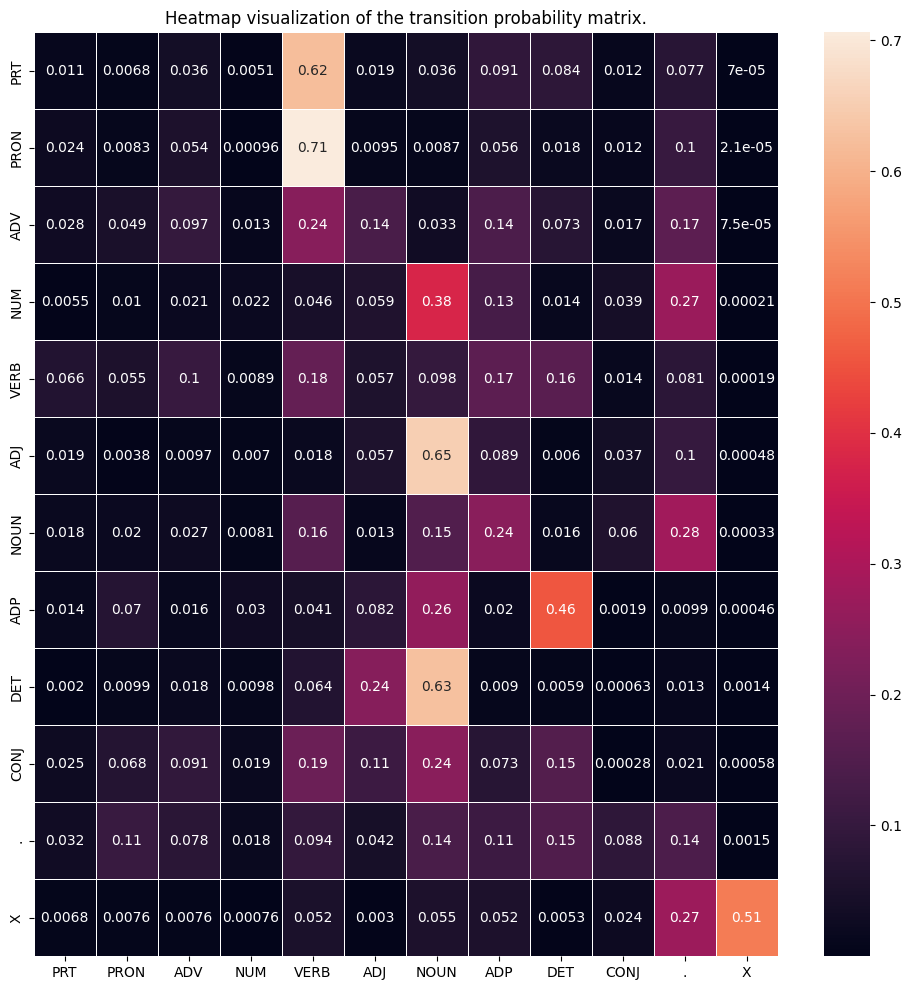

In [15]:
# sample figsize in inches
plt.figure(figsize=(12,12))

sns.heatmap(tpm_df, annot = True, linewidths = .5, xticklabels = True, yticklabels = True)
plt.title('Heatmap visualization of the transition probability matrix.')
plt.show()

We can immediately see that there are "frequent" couples of tags:

| transition | transition probability |
| :-: | :-: |
|PRON $\implies$ VERB | (0.71) |
| ADJ $\implies$ NOUN | (0.65) |
| DET $\implies$ NOUN | (0.63) |
| PRT $\implies$ VERB | (0.62) |
| X $\implies$ X | (0.51) |
| ADP $\implies$ DET | (0.46) |

## Vanilla Viterbi algorithm

In this first version of the algorithm, we we do not - yet - taking into account the possibility to encounter unknown words.

The pseudocode of the algorithm is reported here with some useful notation.

The algorithm returns the most probable sequence of tags $X = (x_0, \dots, x_n)$, where $x_i \in S = (s_1, \dots, s_K), \,\, \forall i = 0, \dots n$ and $S$ is the state space - i.e. the set of all possible POS tags.

Let $Y = (y_0, \dots, y_n)$ be the sequence of observations, where $y_i \in W = (w_1, \dots, w_N), \,\, \forall i = 1, \dots, n$ and $W$ is the observation space - i.e. the vocabulary of all *known* words.

Consider $\pi = (\pi_1, \dots, \pi_K)$ the vector of initial probabilities, meaning that $\pi_i = P(x_0 = s_i), \,\, \forall i = 1, \dots, K$.
<br>
Note: instead of arbitrarily choosing the initial probability of any given tag t, we can simply define it as the emission probability of t given that the previous tag was a punctuation, '.'.

Together with the transition probability matrix, *tpm*, constructed above we need the <font color='red'>emission probability matrix</font>, *epm*, that is - using the just introduced notations - a $K \times N$ matrix whose entries $epm[t,w]$ store the emission probability that tag t generates word w.

In the pseudocode two matrices are used:

- T whose elements $T[i,j]$ store the probabilities of the most probable paths so far $\hat{X} = (\hat{x}_1, \dots, \hat{x}_j)$ with $\hat{x}_j = s_i$ that generates the sequence of observations $(y_1, \dots, y_j)$.
- P whose elements $P[i,j]$ store the tags $\hat{x}_{j-1}$ of the above most probable paths. The entries of the first column are set equal to 0.

<font size="5"><ins>Algorithm</ins></font>:

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0; font-family:monospace;">
function vanilla_viterbi(W, S, pi, Y, tpm, epm) :<br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>for</b> each tag t = 1, ..., K <b>do</b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; T[t,0] = pi[t] * epm[t,0] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; P[t,0] = 0 <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> each observation w = 0, ..., n <b> do </b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> each tag t = 1, ..., K <b>do</b> :<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; T[t,w] = max{T[k, w-1] * tpm[k, t]: k = 1, ..., K} * epm[t,w] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; P[t,w] = argmax{T[k, w-1] * tpm[k, t]: k = 1, ..., K} <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b>end</b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; Z[n] = argmax{T[k,n], k = 1, ..., K} <br>
&nbsp;&nbsp;&nbsp;&nbsp; X[n] = S[Z[n]] <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> for </b> j = n, n-1, ..., 1 <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Z[j-1] = P[Z[j], j] <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; X[j-1] = S[Z[j-1]] <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> end </b> <br>
&nbsp;&nbsp;&nbsp;&nbsp; <b> return </b> X <br>
<b> end </b>
</div>

Given everything we have said, in the actual implementation some subtleties are taken into account:

- we don't need a vector of initial probabilities $\pi$
- instead of introducing the matrix of emission probabilities we can simply compute them using the above *emission_prob* function
- 

In [44]:
# Vanilla Viterbi algorithm to fit the model
# (running it on the whole set of training data takes hours, run it on subsets first)

def vanilla_Viterbi(words, tags = list(T), tpm = tpm_df) :
    n = len(words)
    T = np.zeros( (len(tags), n), dtype=np.float64)
    P = np.zeros( (len(tags), n), dtype=np.int64)
    X = np.empty(n, dtype='object')

    for ind, word in enumerate(words) :
        for pos, t in enumerate(tags) :
            emission_p = emission_prob(word, t)
            if ind == 0 :
                # for each tag t, compute its initial probability as the emission probability of t given that the previous tag was '.'
                T[pos, 0] = tpm.loc['.', t] * emission_p
                P[pos, 0] = 0
            else :
                # for each word different from the first one, the probability of the most probable sequence up to that stage is computed as the 
                # maximum probability of all the possible "ways" there are to reach that tag times the emission probability of that word given the tag
                T[pos, ind] = max(np.multiply(T[:,ind-1], tpm.loc[:, t])) * emission_p
                P[pos, ind] = np.argmax(np.multiply(T[:,ind-1], tpm.loc[:, t]))
        
    # obtain the most probable path proceeding backwards:
    z = np.argmax(T[:,n-1])
    X[n-1]= tags[z]
    for w in range(n-1,0,-1) :
        z = P[z, w]
        X[w-1] = tags[z]

    return X

In [4]:
np.argmax([0,0,0])

0

In [19]:
# prepare the data on which the Viterbi algorithm is to be tested
test_words = [pair[0] for sent in test_data for pair in sent ]

# save the "expected" tags of the test words
test_tags = [pair[1] for sent in test_data for pair in sent]

# for quick initial tests, consider only few sentences of the train data:
# (at this point the algorithm is not yet able to deal with new words)
# accuracy is around 100%
test_words_base = [pair[0] for sent in test_data[0:2] for pair in sent]
test_tags_base = [pair[1] for sent in test_data[0:2] for pair in sent]

In [31]:
start = time.time()
test_out_base = vanilla_Viterbi(test_words_base)
end = time.time()
duration = end - start

print("Time taken in seconds: ", duration)

# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_vit in zip(test_tags_base, test_out_base) if t == t_vit]
accuracy = len(correct)/len(test_words_base)

print("Viterbi algorithm accuracy: ", accuracy)

Time taken in seconds:  166.98252630233765
Viterbi algorithm accuracy:  0.9682539682539683


<ins>ISSUE</ins>: This algorithm is unable to deal with <font color = orange>unknown words</font> or with <font color = lightblue>known words with a unseen syntactical role</font>.

A possible approach to solve the problem of unknown words is to combine the stochastic POS-tagger constructed above with a <font color = red>rule-based</font> POS-tagger. The idea is the following: every time the emission probability - evaluated on the basis of the training data - gives as result 0, a classification based on a set of "lexical rules" is performed.

We start by specifying a set of syntactical patterns that can help us in classifying unknown words.

In [16]:
# specify patterns for tagging
patterns = [
    (r'(.|,|:|;|!)$', '.'),             # punctuations
    (r'(I|You|you|He|he|She|she|It|it|We|we|They|they)$', 'PRON'),   # pronomes
    (r'(But|but|And|and|Or|or)$', 'CONJ'),
    (r'.*ing$', 'VERB'),                # gerund
    (r'.*ed$', 'VERB'),                 # past tense verbs
    (r'.*es$', 'VERB'),                 # singular present verbs
    (r'.*en$', 'VERB'),                 # verbs that mean 'cause to be'
    (r'.*ould$', 'VERB'),               # modal verbs
    (r'(Can|can|Will|will|May|may|might|might)$', 'VERB'),
    (r'.*\'s$', 'NOUN'),                # possessive nouns
    (r'.*s$', 'NOUN'),                  # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),   # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ible$', 'ADJ'),
    (r'.*ful$', 'ADJ'),                 # adjectives
    (r'.*less$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*ive$', 'ADJ'),
    (r'.*ness$', 'NOUN'),               # nouns formed from adjectives
    (r'.*ment$', 'NOUN'),
    (r'.*ion$', 'NOUN'),
    (r'.*ship$', 'NOUN'),
    (r'.*ity$', 'NOUN'),
    (r'.*er$', 'NOUN'),
    (r'.*or$', 'NOUN'),
    (r'.*ee$', 'NOUN'),
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'(Not|not)$', 'ADV'),
    (r'(That|that|This|this|Those|those|These|these)$', 'ADP'),
    (r'(In|in|To|to|At|at|For|for|By|by|From|from|With|with)$', 'ADP'),
    (r'.*', 'NOUN')                     # nouns
]

Once the patterns have been defined, we can use the *nltk.RegexpTagger()* - the built-in Regular Expression Tagger of the library nltk - to assign tags to tokens by comparing their word strings to the constructed series of regular expressions.

In [17]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

Let's see how it performs on a test sentence:

In [90]:
test_rules = rule_based_tagger.tag(test_words_base)

In [94]:
# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_rule in zip(test_tags_base, test_rules) if t == t_rule[1]]
accuracy = len(correct)/len(test_words_base)

print("Rule-based POS tagger accuracy: ", accuracy)

Rule-based POS tagger accuracy:  0.6774193548387096


Obviously, using this rule-based tagger alone is not optimal: the natural language has several subtleties and it is hard to fully depict them with a handful of lexical rules. Nevertheless, it can be combined to the previous Viterbi algorithm in order to help categorize unknown words.

To do so, we clearly have to give a criterion to establish whether a word is unknown. Thanks to our implementation of the model, doing so is quite straightforward:
<center><span style='font-family:serif'><font color = orange> "an unknown word is a word whose emission probability given every possible tag is zero." </font></span> </center>

Relying on this definition, we can modify the above Viterbi algorithm by invoking the just defined rule-based POS tagger on the unknown words.

In [64]:
def Viterbi_ruled(words, tags = list(T), tpm = tpm_df) :
    n = len(words)
    T = np.zeros( (len(tags), n), dtype=np.float64)
    P = np.zeros( (len(tags), n), dtype=np.int64)
    X = np.empty(n, dtype='object')

    for ind, word in enumerate(words) :
        # compute the list of all emission probabilities reltive to the current word
        emission_p = [emission_prob(word, t) for t in tags]

        # check whether all the emission probabilities for the current word are zero
        if max(emission_p) == 0:
            # if so, call the rule-based POS tagger and save the position in the list T of the returned tag
            [(_,rule_tag)] = rule_based_tagger.tag([word])
            ind_rule_tag = tags.index(rule_tag)

            #this tagger is now our only option, we assign it a weight equal to 1
            T[ind_rule_tag, ind] = max(np.multiply(T[:,ind-1], tpm.loc[:, rule_tag]))
            P[ind_rule_tag, ind] = np.argmax(np.multiply(T[:,ind-1], tpm.loc[:, rule_tag]))

        else :
            for pos, t in enumerate(tags) :
                # if the emission probability for the considered tag is zero, we leave everything as it is: the state is never going to be attained
                # else :
                if emission_p[pos] != 0 :
                    if ind == 0 :
                        # for each tag t, compute its initial probability as the emission probability of t given that the previous tag was '.'
                        T[pos, 0] = tpm.loc['.', t] * emission_p[pos]
                        P[pos, 0] = 0
                    else :
                        # for each word different from the first one, the probability of the most probable sequence up to that stage is computed as the 
                        # maximum probability of all the possible "ways" there are to reach that tag times the emission probability of that word given the tag
                        T[pos, ind] = max(np.multiply(T[:,ind-1], tpm.loc[:, t])) * emission_p[pos]
                        P[pos, ind] = np.argmax(np.multiply(T[:,ind-1], tpm.loc[:, t]))
        
    # obtain the most probable path proceeding backwards:
    z = np.argmax(T[:,n-1])
    X[n-1]= tags[z]
    for w in range(n-1,0,-1) :
        z = P[z, w]
        X[w-1] = tags[z]

    return X

In [65]:
start = time.time()
test_out_base = Viterbi_ruled(test_words_base)
end = time.time()
duration = end - start

print("Time taken in seconds: ", duration)

# evaluate the accuracy of the Viterbi algorithm
correct = [t for t, t_vit in zip(test_tags_base, test_out_base) if t == t_vit]
accuracy = len(correct)/len(test_words_base)

print("Viterbi algorithm accuracy: ", accuracy)

Time taken in seconds:  179.46644830703735
Viterbi algorithm accuracy:  0.9682539682539683


<font color = red> ISN'T IT BETTER TO CREATE A VOCABULARY IN WHICH EACH WORD IS FOLLOWED BY ITS POSSIBLE TAG? INSTEAD THAN RUNNING EVERYTIME ON ALL TAGS WE SIMPLY LOOK FOR THE POSSIBLE STATES OF THAT WORD. IF A WORD DOES NOT EXIST, THE RULE BASED VITERBI IS CALLED. 



TRY TO IMPLEMENT A GRAPH IN THE VITERBI



THINK AT IT PREVIOUSLY.... MY CONCERN IS ABOUT HAVING A SPARSE MATRIX T</font>

In [40]:
# get the continuous frequency distribution for the words which are tagged
#cfd_train_words = nltk.ConditionalFreqDist(brown.tagged_words(tagset = 'universal'))

In [41]:
# get the conditional probability distribution
#cpd_train_words=nltk.ConditionalProbDist(cfd_train_words, nltk.MLEProbDist)

In [44]:
#print("The probability of an adjective (JJ) being 'smart' is", cpd_train_words['DET'].prob('The'))
#print("The probability of a verb (VB) being 'try' is", cpd_train_words["VERB"].prob("said"))

The probability of an adjective (JJ) being 'smart' is 0
The probability of a verb (VB) being 'try' is 0


In [45]:
#cpd_train_words

<ConditionalProbDist with 56060 conditions>

IDEA: GRAPH with 12 vertex, the weigths of each edge represent 

In [18]:
import networkx as nx 
from queue import PriorityQueue

class AdjSetGraphD():

    def __init__(self):
        self._vertices = {}
        
    def vertices(self):
        """ returns the vertices of a graph """
        return list(self._vertices.keys())

    def edges(self):
        """ returns the edges of a graph """
        _edges = set()
        for n1 in self._vertices:
            for n2 in self._vertices[n1]:
                _edges.add((n1,n2[0],n2[1]))
        return _edges

    def insertVertex(self, v):
        """ add a vertex """
        if v not in self._vertices:
            self._vertices[v] = set()

    def insertEdge(self, edge, weight):
        """ add an edge """
        """ assumes that edge is of type tuple or list """
        (v1, v2) = tuple(edge)
        
        self.insertVertex(v1)
        self.insertVertex(v2)
        self._vertices[v1].add((v2,weight))
        
    def incidentEdges(self, v):
        """ returns the set of edges incident on a vertex """
        incident_edges = set()
        if v in self._vertices:
            for v2 in self._vertices[v]:
                incident_edges.add((v, v2[0],v2[1]))
        return incident_edges
    
    def neighs(self, v):
        """ returns the set of neighbors of a vertex """
        if v in self._vertices:
            return self._vertices[v]
        return set()
        
    def areAdjacent(self, v1, v2):
        """ checks if the edge exists in the graph """
        if v1 not in self._vertices:
            return False
        for v in self._vertices[v1]:
            if v[0] == v2:
                return True
        return False            
    
    def removeVertex(self, v):
        """ remove a vertex """
        self._vertices.pop(v, None)
        for n in self._vertices:
            self._vertices[n].discard(v)        

    def removeEdge(self, edge):
        """ add an edge """
        (v1, v2) = tuple(edge)
        for v in self._vertices[v1]:
            if v[0] == v2:
                  self._vertices[v1].discard(v)
                  return

    def draw(self):
        """ draw the graph """
        G = nx.DiGraph()
        for e in self.edges():
            G.add_edge(e[0],e[1],weight=e[2])  
        pos = nx.circular_layout(G) 
        weight_labels = nx.get_edge_attributes(G,'weight')
        arc_rad = 0.05
        nx.draw(G, pos, with_labels = True, node_size=600, node_color='#00b4d9', connectionstyle=f'arc3, rad = {arc_rad}') 
        output = nx.draw_networkx_edge_labels(G,pos,edge_labels=weight_labels, label_pos=0.33)     

    def print_shortest(self,path):   
        """ draw the path in the graph """
        """ path is the list of the vertices to traverse """
        """ example: path = ['A', 'C', 'B', 'E'] """
        G = nx.DiGraph()
        for e in self.edges():
            G.add_edge(e[0],e[1],weight=e[2])   
        edges_path = list(zip(path,path[1:]))
        pos = nx.circular_layout(G) 
        weight_labels = nx.get_edge_attributes(G,'weight')
        arc_rad = 0.05
        edge_colors = ['black' if not edge in edges_path else 'red' for edge in G.edges()]
        nx.draw(G, pos, with_labels = True, node_size=600, node_color='#00b4d9', connectionstyle=f'arc3, rad = {arc_rad}', edge_color= edge_colors) 
        output = nx.draw_networkx_edge_labels(G,pos,edge_labels=weight_labels, label_pos=0.33)  

In [20]:
G = AdjSetGraphD()
G.insertVertex(('the', 'DET'))
G.insertVertex(('fans', 'NOUN'))
G.insertVertex(('fans', 'VERB'))
G.insertEdge((('the', 'DET'), ('fans', 'NOUN')), 0.1)
G.insertEdge((('the', 'DET'), ('fans', 'VERB')), 0.2)

#G.draw()
G.incidentEdges(('the', 'DET'))


{(('the', 'DET'), ('fans', 'NOUN'), 0.1),
 (('the', 'DET'), ('fans', 'VERB'), 0.2)}

In [34]:
G = nx.DiGraph()
G.add_edge(('the', 'DET'), ('fans', 'NOUN'), weight = 0.1)
G.add_edge(('the', 'DET'), ('fans', 'VERB'), weight = 0.2)

list(G.in_edges(('fans', 'VERB')))[0][0]

('the', 'DET')

In [62]:
def graph_Viterbi(words, tags = list(T), tpm = tpm_df) :
    n = len(words)
    T = AdjSetGraphD()
    T.insertVertex(('.', '.'))
    # vector of tuples to save previous step probabilities
    temp = np.zeros(len(tags), dtype=np.float64)
    temp[tags.index('.')] = 1
    #T = np.zeros( (len(tags), n), dtype=np.float64)
    #P = np.zeros( (len(tags), n), dtype=np.int64)
    X = np.empty(n, dtype='object')

    for ind, word in enumerate(words) :
        for pos, tag in enumerate(tags) :

            emission_p = emission_prob(word, tag)
            pred = np.argmax(np.multiply(temp, tpm.loc[:, tag]))
            prob_max = max(np.multiply(temp, tpm.loc[:, tag]))

            if emission_p != 0 :
                weight = prob_max * emission_p
                temp[pos] = weight
                T.insertVertex((word, tag))
                if ind != 0 :
                    T.insertEdge(((words[ind-1], tags[pred]), (word, tag)), weight)
                else :
                    T.insertEdge((('.', '.'), (word, tag)), weight)
            else :
                temp[pos] = 0

            # if the current word is unknown, all the emission probabilities will be zero
            if max(temp) == 0 :
                [(_,rule_tag)] = rule_based_tagger.tag([word])
                T.insertVertex((word, rule_tag))
                if ind != 0 :
                    T.insertEdge(((words[ind-1], tags[pred]), (word, rule_tag)), prob_max)
                else :
                    T.insertEdge((('.', '.'), (word, rule_tag)), prob_max)
                
                ind_rule_tag = tags.index(rule_tag)
                temp[ind_rule_tag] = 1
                
        
    # obtain the most probable path proceeding backwards:
    z = np.argmax(temp)
    X[n-1]= tags[z]
    for w in range(n-1,0,-1) :
    #    z = P[z, w]
    #    X[w-1] = tags[z]

    return T

In [55]:
simple_example = ['It', 'is', 'beautiful']

G, X = graph_Viterbi(simple_example)

In [46]:
X1 = vanilla_Viterbi(simple_example)

In [47]:
X1

array(['PRON', 'VERB', 'ADJ'], dtype=object)

In [57]:
X

array([('It', 'PRON'), ('is', 'VERB'), ('beautiful', 'ADJ')], dtype=object)

In [54]:
def graph_Viterbi(words, tags = list(T), tpm = tpm_df) :
    n = len(words)
    T = nx.DiGraph()
    # vector of tuples to save previous step probabilities
    pred = np.zeros(len(tags), dtype=np.float64)
    pred[tags.index('.')] = 1
    current = np.zeros(len(tags), dtype=np.float64)
    #T = np.zeros( (len(tags), n), dtype=np.float64)
    #P = np.zeros( (len(tags), n), dtype=np.int64)
    X = np.empty(n, dtype='object')

    for ind, word in enumerate(words) :
        for pos, tag in enumerate(tags) :

            emission_p = emission_prob(word, tag)
            ind_pred = np.argmax(np.multiply(pred, tpm.loc[:, tag]))
            prob_max = max(np.multiply(pred, tpm.loc[:, tag]))

            if emission_p != 0 :
                weight = prob_max * emission_p
                # NON PUOI MODIFICARE QUI TEMP!!
                current[pos] = weight
                if ind != 0 :
                    T.add_edge((words[ind-1], tags[ind_pred]), (word, tag), weight = weight)
                else :
                    T.add_edge(('.', '.'), (word, tag), weight = weight)
            else :
                current[pos] = 0

        # if the current word is unknown, all the emission probabilities will be zero
        if max(current) == 0 :
            [(_,rule_tag)] = rule_based_tagger.tag([word])
            ind_pred = np.argmax(np.multiply(pred, tpm.loc[:, rule_tag]))
            prob_max = max(np.multiply(pred, tpm.loc[:, rule_tag]))
            if ind != 0 :
                T.add_edge((words[ind-1], tags[ind_pred]), (word, rule_tag), weight = prob_max)
            else :
                T.add_edge(('.', '.'), (word, rule_tag), weight = prob_max)
            
            ind_rule_tag = tags.index(rule_tag)
            current[ind_rule_tag] = 1
        
        for i, p in enumerate(current) :
            pred[i] = p
                
        
    # obtain the most probable path proceeding backwards:
    z = np.argmax(pred)
    X[n-1]= (words[n-1], tags[z])
    for w in range(n-1,0,-1) :
        X[w-1] = list(T.in_edges(X[w]))[0][0]
    #    z = P[z, w]
    #    X[w-1] = tags[z]

    return T, X